### week 2

# Objective Functions

- regression analysis
- prediction function and least squares error function
- gradient (or steepest) descent algorithm
- stochastic gradient descent

In [1]:
import pods
import notebook as nb
import mlai
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

### Review and Preview

- last week we motivated the importance of probability
- this week we look at the idea of objective functions

### Objective Functions

Two dominating approaches to machine learning problems:

- constructing models by defining the relationship between variables using probabilities (last week)
- defining an *objective function* and optimising it (this week)

An objective function can be either

- error function
- cost function
- benefit function

### Machine Learning Using an Objective Function

We write down a mathematical equation which is then optimised to do the learning.

- the equation should be a function of the *data* and our model *parameters*.
- in the optimisation field we always choose to minimise the function (if we have function that we would like to maximise, we simply choose to minimise the negative of that function).

Wikipedia: [Loss function](https://en.wikipedia.org/wiki/Loss_function)

### Overdetermined and Underdetermined Systems

Each unknown can be seen as an available degree of freedom, while each equation constrains the system, restricting one degree of freedom.

##### Overdetermined system:

- the system has been overconstrained
- there are more equations than unknowns

##### Underdetermined system:

- the system has been underconstrained
- the number of equations is fewer than the number of unknowns

### Classification

- classification is a schematic that shows the organisation of data starting with a precursor variable
- map data point to a class label
- dependent variables are categorical and unordered

<img src="https://upload.wikimedia.org/wikipedia/commons/4/46/Linear-svm-scatterplot.svg", width=400>


### Regression

- regression is a prediction method that is based on an assumed or known numerical output value
- map feature to a real value
- dependent variables are continuous or ordered whole values

<img src="https://upload.wikimedia.org/wikipedia/commons/b/be/Normdist_regression.png", width=360>

### What is Machine Learning?

**<center>data + model = prediction</center>**

- **data**: observations - could be actively or passively acquired (meta-data)
- **model**: assumptions - based on previous experience, or beliefs about the regularities of the universe
- **prediction**: an action to be taken, a categorization or a quality score

### Prediction Function

Suppose a set of $n$ data points $(x_1, y_1),\ldots,(x_n, y_n)$ is given.

A linear *prediction function* is
$$
    f(x_i) = mx_i + c
$$
where $m$ and $c$ denote a slope and an offset.

We need an algorithm to fit $f(x_i)$ to data.

### Error Function (Objective Function)

- regression analysis is a statistical process for estimating the relationships among variables.
- in regression analysis least squares is a standard approach to soluving overdetermined systems.

*Least squares* is an error function that minimises a sum of squared errors between real value $y_i$ and the prediction $f(x_i)$:
$$
    E(m, c) = \sum_{i=1}^n (y_i - f(x_i))^2 = \sum_{i=1}^n (y_i - mx_i - c)^2
$$

### Data Set

Let's start with creating an artifical data set.

In [2]:
x = np.random.normal(size=4)  # create four (4) data points
x

array([ 0.36583193, -0.55392598,  0.08951493,  0.04675371])

We now need to decide on a *true* value for $m$ and a *true* value for $c$ to use for generating the data. 

In [3]:
m_true = 1.4  # true value for slope
c_true = -3.1  # true value for offset

We can use these values to create our artificial data. The formula
$$
    y_i = mx_i + c
$$
is translated to code as follows:

In [4]:
y = m_true * x + c_true
y

array([-2.5878353 , -3.87549638, -2.9746791 , -3.03454481])

We can now plot the artifical data we've created.

(-3, 3)

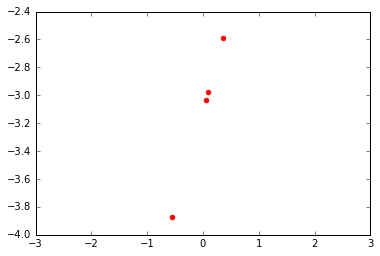

In [5]:
plt.plot(x, y, 'r.', markersize=10)  # plot data as red dots
plt.xlim([-3, 3])

These points lie exactly on a straight line, that's not very realistic, let's corrupt them with a bit of Gaussian 'noise'.

(-3, 3)

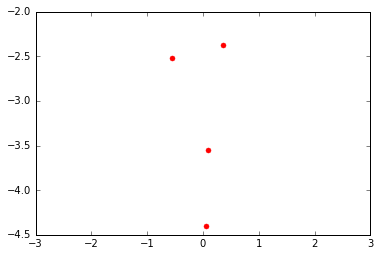

In [6]:
noise = np.random.normal(scale=0.5, size=4)  # standard deviation of the noise: 0.5
y = m_true * x + c_true + noise
plt.plot(x, y, 'r.', markersize=10)
plt.xlim([-3, 3])

### Contour Plot of Error Function

Here we visualise the error function surface, create vectors of values.

In [7]:
# create an array of linearly separated values around m_true/c_true
m_vals = np.linspace(m_true-3, m_true+3, 100)
c_vals = np.linspace(c_true-3, c_true+3, 100)

# create a grid of values to evaluate the error function in 2D
m_grid, c_grid = np.meshgrid(m_vals, c_vals)

# compute the error function at each combination of c and m
E_grid = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        E_grid[i, j] = ((y - m_grid[i, j] * x - c_grid[i, j])**2).sum()

We can now make a contour plot.

In [8]:
# define a function for contour plot
def regression_contour(f, ax, m_vals, c_vals, E_grid):

    # contour plot
    hcont = ax.contour(m_vals, c_vals, E_grid, levels=[0, 0.5, 1, 2, 4, 8, 16, 32, 64])

    # contour labels
    plt.clabel(hcont, inline=1, fontsize=15)

    # axis labels
    ax.set_xlabel('$m$', fontsize=25)
    ax.set_ylabel('$c$', fontsize=25)

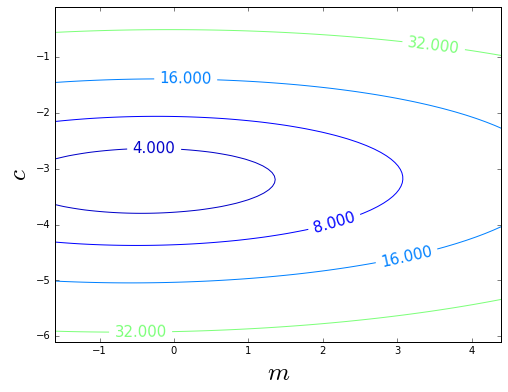

In [9]:
f, ax = plt.subplots(figsize=(8, 6))
regression_contour(f, ax, m_vals, c_vals, E_grid)
plt.savefig('./diagrams/regression_contour.svg')  # saving the figure

### Gradient (or Steepest) Descent Algorithm

We would like to minimise the sum of squares error function:
$$
    E(m, c) = \sum_{i=1}^n (y_i - mx_i - c)^2
$$
One way of doing this is gradient descent.

- $m$ and $c$ are initialised by a guess, which is updated by subtracting a portion of the gradient from the guess.
- it is like walking down a hill in the steepest direction of the hill to approach the bottom.

Wikipedia: [Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)

We start with a guess for a slope $m$ and an offset $c$.

In [10]:
m_star = 0.0  # guess (initial value) for slope
c_star = -5.0  # guess (initial value) for offset

### Offset Gradient

Firstly we calculate the gradient of the error function with respect to the offset $c$:
$$
    \frac{\partial}{\partial c} E(m, c) = -2\sum_{i=1}^n (y_i - mx_i - c)
$$
This is computed in python as follows:

In [11]:
c_grad = -2 * (y - m_star * x - c_star).sum()
print("Gradient with respect to c is", c_grad)

Gradient with respect to c is -14.3080723336


#### (note) deriving the gradient

To see how the gradient was derived, first note that the $c$ appears in every term in the sum. So we are just differentiating $(y_i - mx_i - c)^2$ for each term in the sum. The gradient of this term with respect to $c$ is simply the gradient of the outer quadratic, multiplied by the gradient with respect to $c$ of the part inside the quadratic. The gradient of a quadratic is two times the argument of the quadratic, and the gradient of the inside linear term is just minus one. This is true for all terms in the sum, so we are left with the sum in the gradient.

### Slope Gradient

The gradient with respect to $m$ is similar, but now the gradient of the quadratic's argument is $-x_i$, thus
$$
    \frac{\partial}{\partial m} E(m, c) = -2\sum_{i=1}^n x_i(y_i - mx_i - c)
$$
which can be implemented in python (numpy) as follows.

In [12]:
m_grad = -2 * (x * (y - m_star * x - c_star)).sum()
print("Gradient with respect to m is", m_grad)

Gradient with respect to m is 0.519057945068


### Gradient Descent: Update Equations

Now we have gradients with respect to $m$ and $c$.

- we can update our inital guesses for $m$ and $c$ using the gradient.
- we don't want to just subtract the gradient from $m$ and $c$, instead we need to take a *small* step in the gradient direction; otherwise we might overshoot.
- we want to follow the gradient to reach the minimum; the gradient changes all the time.

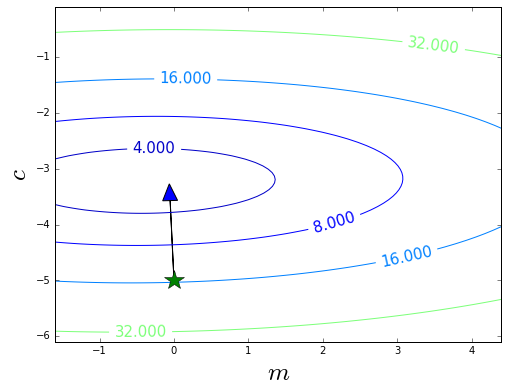

In [13]:
f, ax = plt.subplots(figsize=(8,6))
regression_contour(f, ax, m_vals, c_vals, E_grid)
ax.plot(m_star, c_star, 'g*', markersize=20)  # current position
ax.arrow(m_star, c_star, -m_grad*0.1, -c_grad*0.1, head_width=0.2)  # direction of the gradient
plt.savefig('./diagrams/regression_contour_step1.svg')  # saving the figure

$c_\text{new}$ and $m_\text{new}$ give us an update for our estimate of $c$ and $m$:
\begin{align*}
    c_\text{new} & \leftarrow c_{\text{old}} - \eta \frac{\partial}{\partial c} E(m, c) \\
    m_\text{new} & \leftarrow m_{\text{old}} - \eta \frac{\partial}{\partial m} E(m, c)
\end{align*}

- the step size is known as the learning rate and is denoted by $\eta$.
- in the code we've been calling `c_star` and `m_star` to represent a common way of writing parameter estimates, $c^*$ and $m^*$.

These updates can be coded as the following.

In [14]:
learn_rate = 0.01  # learning rate
print("The learning rate is", learn_rate)
print("Initially, m was", m_star, "and c was", c_star)
c_star = c_star - learn_rate * c_grad
m_star = m_star - learn_rate * m_grad
print("After one update, m is", m_star, "and c is", c_star)

The learning rate is 0.01
Initially, m was 0.0 and c was -5.0
After one update, m is -0.00519057945068 and c is -4.85691927666


By iterating updates we are descending gradient, gradually fitting the model.

In [15]:
# define a function for iterating gradient calculation
def regression_contour_fit(ax, iterations, learn_rate, m_star, c_star, x, y):
    for i in range(iterations):

        # update offset
        c_grad = -2 * (y - m_star * x - c_star).sum()
        c_star = c_star - learn_rate * c_grad

        # update slope
        m_grad = -2 * (x * (y - m_star * x - c_star)).sum()
        m_star = m_star - learn_rate * m_grad

        # plot the current position
        ax.plot(m_star, c_star, 'g*', markersize=10)

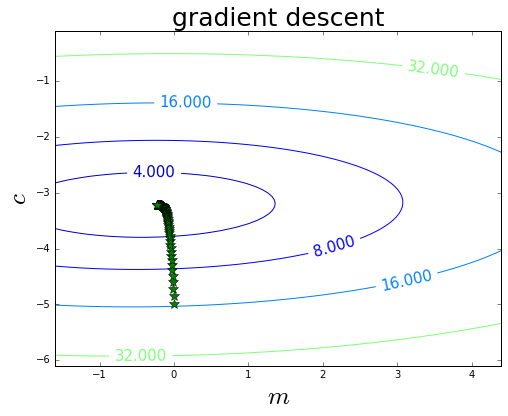

In [16]:
# contour plot
f, ax = plt.subplots(figsize=(8, 6))
regression_contour(f, ax, m_vals, c_vals, E_grid)
ax.set_title('gradient descent', fontsize=25)

# plot the initial position
m_star = 0.0
c_star = -5.0
ax.plot(m_star, c_star, 'g*', markersize=10)

# plot the updated positions
iterations = 100  # number of iterations
learn_rate = 0.01  # learning rate
regression_contour_fit(ax, iterations, learn_rate, m_star, c_star, x, y)

### Stochastic Gradient Descent Algorithm

If the number of data points $n$ is small, gradient descent is fine, but sometimes (eg. 'Big Data') $n$ could be a billion.

- stochastic gradient descent is more similar to perceptron.
- it looks at gradient of one data point at a time rather than summing across *all* data points.
- this gives a stochastic estimate of gradient.

Wikipedia: [Stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

The real gradient with respect to $m$ is given by
$$
    \frac{\partial}{\partial m} E(m, c) = -2\sum_{i=1}^n x_i(y_i - mx_i - c)
$$
but it has $n$ terms in the sum. Substituting in the gradient we can see that the full update is of the form:
$$
    m_\text{new} \leftarrow m_\text{old} + 2\eta \left\{x_1 (y_1 - m_\text{old}x_1 - c_\text{old}) + x_2 (y_2 - m_\text{old}x_2 - c_\text{old}) + \ldots + x_n (y_n - m_\text{old}x_n - c_\text{old})\right\}
$$

This could be split up into lots of individual updates:
\begin{align*}
    m_1 & \leftarrow m_\text{old} + 2\eta x_1 (y_1 - m_\text{old}x_1 - c_\text{old}) \\
    m_2 & \leftarrow m_1 + 2\eta x_2 (y_2 - m_\text{old}x_2 - c_\text{old}) \\
        & \dots \\
    m_{new} & \leftarrow m_{n-1} + 2\eta x_n (y_n - m_\text{old}x_n - c_\text{old})
\end{align*}
which would lead to the same final update.
Here is one observation:

- in the sum we don't change $m_\text{old}$ and $c_\text{old}$ used for computing the gradient term at each update.

In *stochastic gradient descent* we *do* change them. This means it's not quite the same as gradient descent.

### Stochastic Gradient Descent: Updating $c$ and $m$

We can present each data point in a random order, like we did for the perceptron.

- this makes the algorithm suitable for large scale web use.
- recently this domain is know as 'Big Data'.
- algorithms like this are widely used by Google, Microsoft, Amazon, Twitter and Facebook.

Or more accurately, since the data is normally presented in a random order, we just can write
$$
    m_\text{new} = m_\text{old} + 2\eta \left\{ x_i (y_i - m_\text{old}x_i - c_\text{old}) \right\}
$$

In [17]:
# choose a random point for the update
i = np.random.randint(x.shape[0] - 1)

# update slope
m_star = m_star + 2 * learn_rate * x[i] * (y[i] - m_star*x[i] - c_star)

# update offset
c_star = c_star + 2 * learn_rate * (y[i] - m_star*x[i] - c_star)

Putting them all together in an algorithm, we can do stochastic gradient descent for our regression data.

In [18]:
# define a function for stochastic gradient calculation
def regression_contour_sgd(ax, learn_rate, m_star, c_star, x, y):

    # choose a random point for the update
    i = np.random.randint(x.shape[0] - 1)

    # update slope
    m_star = m_star + 2 * learn_rate * x[i] * (y[i] - m_star*x[i] - c_star)

    # update offset
    c_star = c_star + 2 * learn_rate * (y[i] - m_star*x[i] - c_star)

    # plot the current position
    ax.plot(m_star, c_star, 'g*', markersize=10)

    # return updates
    return m_star, c_star

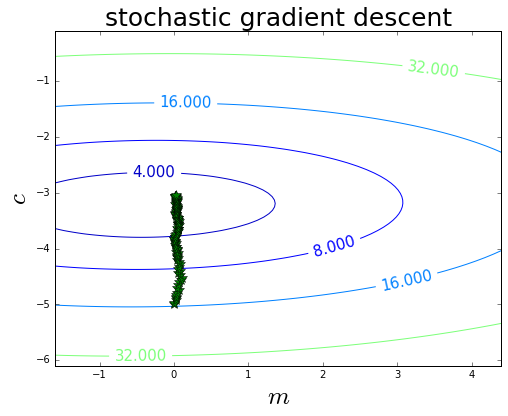

In [19]:
# contour plot
f, ax = plt.subplots(figsize=(8, 6))
regression_contour(f, ax, m_vals, c_vals, E_grid)
ax.set_title('stochastic gradient descent', fontsize=25)

# plot the initial position
m_star = 0.0
c_star = -5.0
ax.plot(m_star, c_star, 'g*', markersize=10)

# plot the updated positions
iterations = 100  # number of iterations
learn_rate = 0.01  # learning rate
for i in range(iterations):
    m_star, c_star = regression_contour_sgd(ax, learn_rate, m_star, c_star, x, y)

### Reflection: Linear Regression and Supervised Learning

Think about:

1. What effect does the learning rate have in the optimisation? What's the effect of making it too small, what's the effect of making it too big? Do you get the same result for both stochastic and steepest gradient descent?

2. The stochastic gradient descent doesn't help very much for such a small data set. It's real advantage comes when there are many, you'll see this in the lab.
